In [82]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None)

# DBSCAN with Multiple Data Sets

Read [here](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) if math excites you.

## Dataset 1

In [86]:
df = pd.read_csv("https://raw.githubusercontent.com/RAHULKASHYAP02/Credit-Card-Segmentation/master/CC%20GENERAL.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Preprocessing

In [87]:
df=df.drop(columns=['CUST_ID'])

In [88]:
df_copy.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
diff_col                            0
diff_col_powered                    0
dtype: int64

In [89]:
#we filled the null values with mean values
#My solution
df_copy.fillna(df.mean(axis = 0) , axis = 0 , inplace = True)

In [90]:
#solution (dropping columns)
## separating the categorical features and numerical features again
num_cols = list(set(df_copy.describe().columns.to_list()) - set(['Id']))
cat_cols = list(set(df_copy.columns.to_list()) - set(num_cols) - set(['Id']))

# inspecting the correlation between each couple of features
num_cols_wthout_response_variable = list(set(num_cols) - set(['PURCHASES']))
corr_matrix = df_copy[num_cols_wthout_response_variable].corr()
corr_matrix

,PURCHASES_TRX,BALANCE,TENURE,MINIMUM_PAYMENTS,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,ONEOFF_PURCHASES,CASH_ADVANCE_TRX,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,BALANCE_FREQUENCY,diff_col,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE,diff_col_powered,PRC_FULL_PAYMENT,PURCHASES_INSTALLMENTS_FREQUENCY
PURCHASES_TRX,1.000000,-0.068428,NaN,-0.030853,0.179337,0.783664,0.562470,-0.401444,0.618903,0.243732,0.163200,NaN,0.920082,-0.373586,-0.451457,NaN,0.271334,0.758995
BALANCE,-0.068428,1.000000,NaN,0.851083,0.297029,-0.143579,0.154983,0.517953,0.144464,0.445489,0.560942,NaN,-0.123088,0.492887,0.528221,NaN,-0.531370,-0.125600
TENURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MINIMUM_PAYMENTS,-0.030853,0.851083,NaN,1.000000,0.270030,-0.071097,0.060147,0.452679,0.056060,0.376706,0.494934,NaN,-0.071907,0.422658,0.440882,NaN,-0.434157,-0.054485
CREDIT_LIMIT,0.179337,0.297029,NaN,0.270030,1.000000,0.095112,0.271700,0.109378,0.286474,0.456532,0.096043,NaN,0.112047,0.122156,0.107433,NaN,0.025901,0.053520
INSTALLMENTS_PURCHASES,0.783664,-0.143579,NaN,-0.071097,0.095112,1.000000,0.151268,-0.362496,0.185837,0.148343,0.086690,NaN,0.796329,-0.340611,-0.400998,NaN,0.288163,0.877719
ONEOFF_PURCHASES,0.562470,0.154983,NaN,0.060147,0.271700,0.151268,1.000000,-0.162963,0.847531,0.319437,0.105651,NaN,0.370802,-0.146361,-0.195544,NaN,0.016099,0.089830
CASH_ADVANCE_TRX,-0.401444,0.517953,NaN,0.452679,0.109378,-0.362496,-0.162963,1.000000,-0.164625,0.221093,0.169756,NaN,-0.396655,0.948453,0.921909,NaN,-0.317777,-0.328523
ONEOFF_PURCHASES_FREQUENCY,0.618903,0.144464,NaN,0.056060,0.286474,0.185837,0.847531,-0.164625,1.000000,0.341982,0.172951,NaN,0.494181,-0.142642,-0.192096,NaN,0.104730,0.138670
PAYMENTS,0.243732,0.445489,NaN,0.376706,0.456532,0.148343,0.319437,0.221093,0.341982,1.000000,0.180117,NaN,0.170474,0.216907,0.223074,NaN,0.111039,0.113892


In [91]:
cat_cols

[]

In [92]:
#third issue
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

Scaler1 = preprocessing.MinMaxScaler()
df_scaled = pd.DataFrame(Scaler1.fit_transform(df_copy) , columns=df_copy.columns)

In [93]:
#test
print(Scaler1.data_min_)
print(Scaler1.data_max_)

[ 1.03090002  0.45542745  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  5.27639235  3.73274544  2.76589145  0.         12.          0.
  0.        ]
[ 8.5256693   0.52658903  7.9378237   7.31263688  7.09972803  7.9490779
  1.          0.47383089  1.          0.39575668  2.39789527  3.79548919
  9.53611271  8.35494148  7.50165835  0.29884994 12.          0.
  0.        ]


In [96]:
# IQR method to clamp outliers
def outliers_clamping(col, value):
    Q1 = np.percentile(df_copy[col], q= 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_copy[col], q=75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    Upper_Bound = Q3 + 1.5*IQR
    Lower_Bound = Q1 - 1.5*IQR
    if value > Upper_Bound:
        return Upper_Bound
    elif value < Lower_Bound :
        return Lower_Bound
    else:
        return value

In [97]:
#make copy of data
df_copy=df.copy()

In [98]:
df_copy.dropna(inplace=True)
df_copy.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [100]:
def outliers_clamping(col, value):
    Q1 = np.percentile(df_copy[col], q= 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_copy[col], q=75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    Upper_Bound = Q3 + 1.5*IQR
    Lower_Bound = Q1 - 1.5*IQR
    if value > Upper_Bound:
        return Upper_Bound
    elif value < Lower_Bound :
        return Lower_Bound
    else:
        return value

In [101]:
for col in df_copy.columns:
    df_copy[col] = df_copy[col].apply(lambda x: outliers_clamping(col, x))

In [102]:

def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    df['diff_col'] = df[col] - mean_col
    df['diff_col_powered'] = np.power(df['diff_col'], 3)
    skewness = np.sum(df['diff_col_powered'])/((size_rows - 1) * np.power(std_col, 3))
    df = df.drop(columns = ['diff_col_powered', 'diff_col'])
    return skewness

def skewed_data_transformation(value, skewness):
    if (skewness >= 1 or skewness <= -1) and value >= 0:
        return np.log(1+ value)
    else:
        return value

In [103]:
for col in df_copy.columns:
    sk = skewness_calc(col, df_copy)
    df_copy[col] = df_copy[col].apply(lambda x: skewed_data_transformation(x, sk))

In [104]:
df_copy.drop(columns=['diff_col','diff_col_powered'])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3.735304,0.597837,4.568506,0.000000,4.568506,0.000000,0.166667,0.000000,0.083333,0.000000,0.000000,1.098612,6.908755,5.312231,4.945277,0.000000,12
1,8.071989,0.646627,0.000000,0.000000,0.000000,7.949078,0.000000,0.000000,0.000000,0.223144,1.609438,0.000000,8.853808,8.319725,6.978531,0.200671,12
2,7.822504,0.693147,6.651791,6.651791,0.000000,0.000000,1.000000,0.559616,0.000000,0.000000,0.000000,2.564949,8.922792,6.434654,6.442994,0.000000,12
4,6.707735,0.693147,2.833213,2.833213,0.000000,0.000000,0.083333,0.080042,0.000000,0.000000,0.000000,0.693147,7.090910,6.521114,5.504483,0.000000,12
5,7.501540,0.693147,7.196147,0.000000,7.066947,0.000000,0.666667,0.000000,0.583333,0.000000,0.000000,2.197225,7.496097,7.244983,7.501658,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,1.927413,0.572519,3.086487,3.086487,0.000000,0.000000,0.166667,0.154151,0.000000,0.000000,0.000000,0.693147,6.216606,4.088408,3.794898,0.000000,12
8945,3.384170,0.693147,5.677165,0.000000,5.677165,0.000000,1.000000,0.000000,0.833333,0.000000,0.000000,1.945910,6.908755,5.788719,3.909748,0.348307,12
8947,3.194529,0.606136,4.979489,0.000000,4.979489,0.000000,0.833333,0.000000,0.666667,0.000000,0.000000,1.791759,6.908755,4.410016,4.423869,0.223144,12
8948,2.671218,0.606136,0.000000,0.000000,0.000000,3.625907,0.000000,0.000000,0.000000,0.154151,1.098612,0.000000,6.216606,3.980615,4.038755,0.223144,12


# Features transformation

In [105]:
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_copy)

# DBscan

In [106]:
db2 = DBSCAN(eps = 0.5, min_samples =15).fit(scaled_df)
db2

DBSCAN(min_samples=15)

In [107]:
db2.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [108]:
silhouette_score(df_copy,db2.labels_)

-0.4236785709069638

In [109]:
from sklearn.decomposition import PCA, FactorAnalysis
pca = PCA(n_components =2)  
pca.fit(df_copy)
x_pca = pca.transform(df_copy)
x_pca.shape

(8636, 2)

In [110]:
pd.set_option('display.max_columns', None)

In [111]:
x_pca

array([[-1.1483388 ,  5.58267391],
       [ 8.56585568, -0.72705799],
       [-2.58626425, -1.65996684],
       ...,
       [-1.85494625,  5.88524847],
       [ 5.53641171,  5.23160143],
       [-0.51194932, -3.26012149]])

In [112]:
x_pca=pd.DataFrame(x_pca, columns = ['x','y'])
x_pca.shape

(8636, 2)

In [113]:
db = DBSCAN(eps = 0.5, min_samples = 15).fit(x_pca)
db.labels_

array([0, 1, 0, ..., 0, 1, 0])

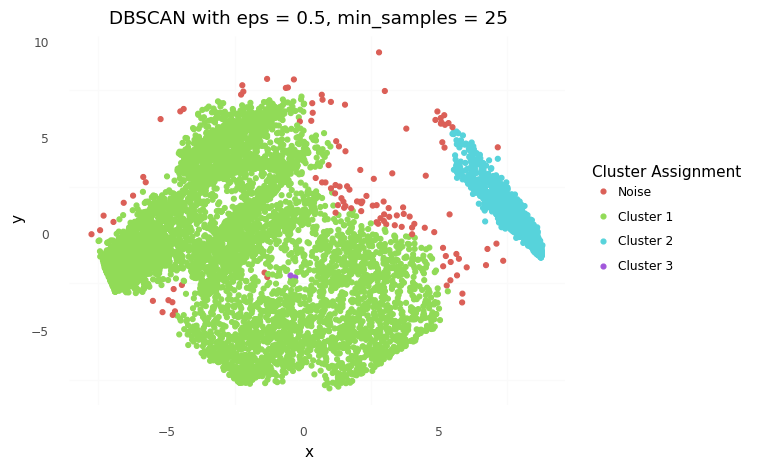

<ggplot: (8744527455845)>

In [114]:
db = DBSCAN(eps = 0.5, min_samples = 15).fit(x_pca)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db.labels_)))]

x_pca["assignments"]=db.labels_

(ggplot(x_pca, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 25"))

In [115]:
d2_clustered = x_pca.loc[(x_pca.assignments >= 0)]

print(silhouette_score(d2_clustered[["x","y"]], d2_clustered["assignments"]))

print(silhouette_score(x_pca[["x","y"]], x_pca["assignments"]))

0.07581344254263593
0.04396885839226219


# Compare

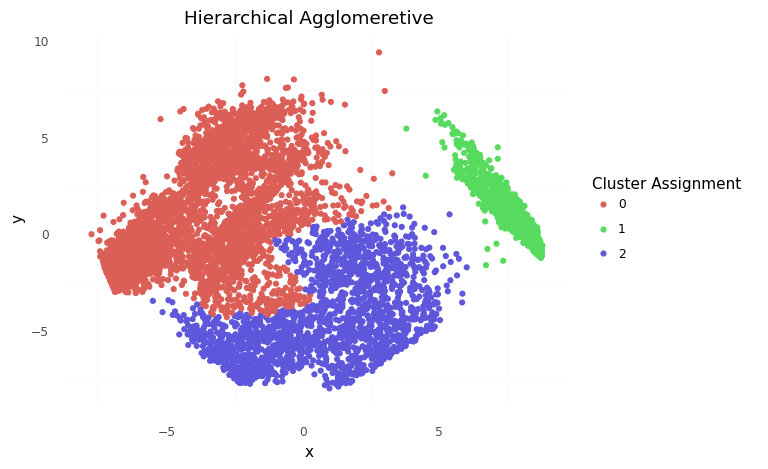

<ggplot: (8744527143405)>


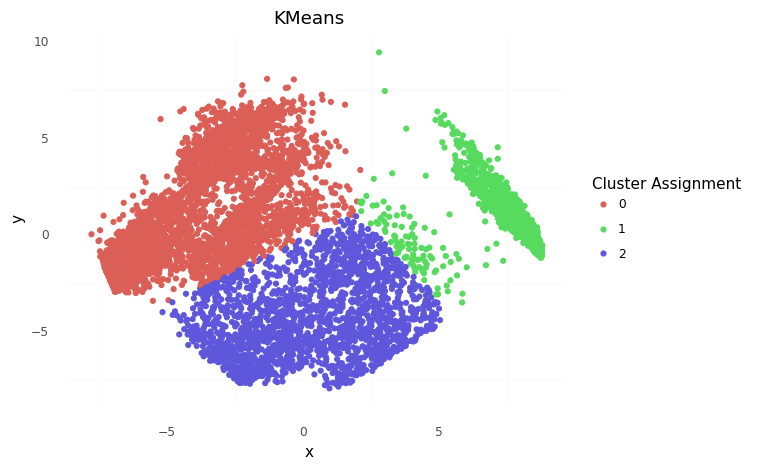

<ggplot: (8744526845649)>


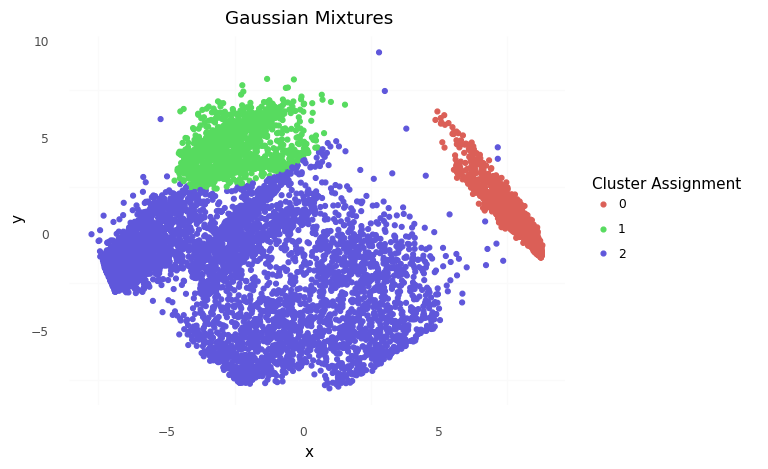

<ggplot: (8744526957069)>


In [116]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

hac = AgglomerativeClustering(3)
km = KMeans(3)
gm = GaussianMixture(3)

hac.fit(x_pca[["x","y"]])
km.fit(x_pca[["x","y"]])
gm.fit(x_pca[["x","y"]])
x_pca["hac"] = hac.labels_
x_pca["km"] = km.labels_
x_pca["gm"] = gm.predict(x_pca[["x","y"]])


print(ggplot(x_pca, aes(x = "x", y = "y",
                    color = "factor(hac)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Hierarchical Agglomeretive"))


print(ggplot(x_pca, aes(x = "x", y = "y",
                    color = "factor(km)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "KMeans"))


print(ggplot(x_pca, aes(x = "x", y = "y",
                    color = "factor(gm)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Gaussian Mixtures"))

In [117]:
mins = 3
nn = NearestNeighbors()

nn.fit(x_pca)

distances, neighbors = nn.kneighbors(x_pca)

distances

array([[0.        , 0.0198206 , 0.06096906, 0.09293047, 0.11292932],
       [0.        , 0.01273328, 0.02572144, 0.03228511, 0.03257996],
       [0.        , 0.0649147 , 0.06813671, 0.07076352, 0.09323768],
       ...,
       [0.        , 0.01250911, 0.0392388 , 0.04487971, 0.05377012],
       [0.        , 0.04520787, 0.09552996, 0.17044127, 0.17491833],
       [0.        , 0.07451726, 0.09819853, 0.13337067, 0.14119819]])

In [118]:
# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

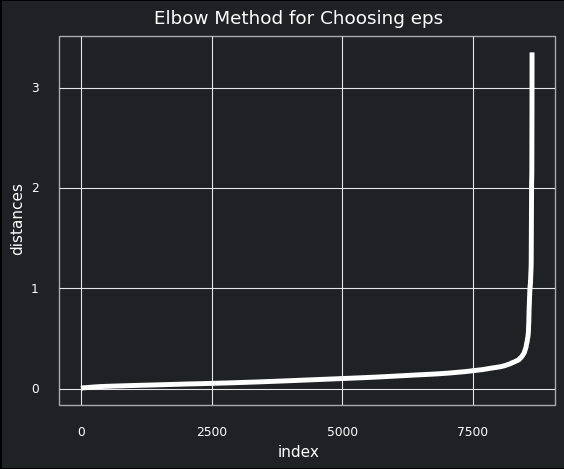

<ggplot: (8744526751757)>

In [119]:
#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
plt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "white", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
 theme(panel_grid_minor = element_blank(),
      rect = element_rect(fill = "#202124ff"),
      axis_text = element_text(color = "white"),
      axis_title = element_text(color = "white"),
      plot_title = element_text(color = "white"),
      panel_border = element_line(color = "darkgray"),
      plot_background = element_rect(fill = "#202124ff")
      ))
ggsave(plot=plt, filename='elbow.png', dpi=300)

plt

In [120]:
# grab only clustered data points
d_clustered = x_pca.loc[(x_pca.assignments >= 0)]

print(silhouette_score(d_clustered[["x","y"]], d_clustered["assignments"]))

# overall 
print(silhouette_score(x_pca[["x","y"]], x_pca["assignments"]))

0.07581344254263593
0.04396885839226219


# Dataset1

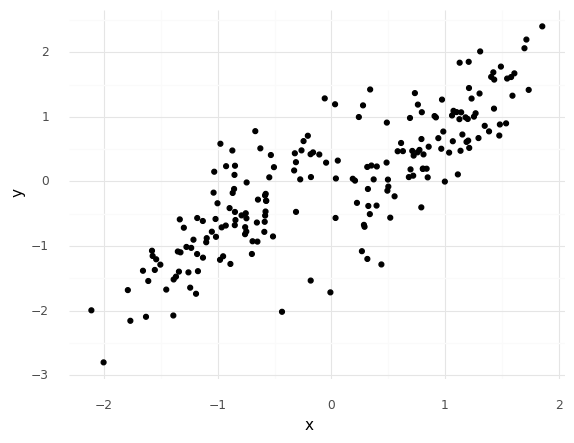

<ggplot: (8744526663945)>

In [121]:
d1 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM1.csv")

z = StandardScaler()
d1[["x","y"]] = z.fit_transform(d1)

ggplot(d1, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

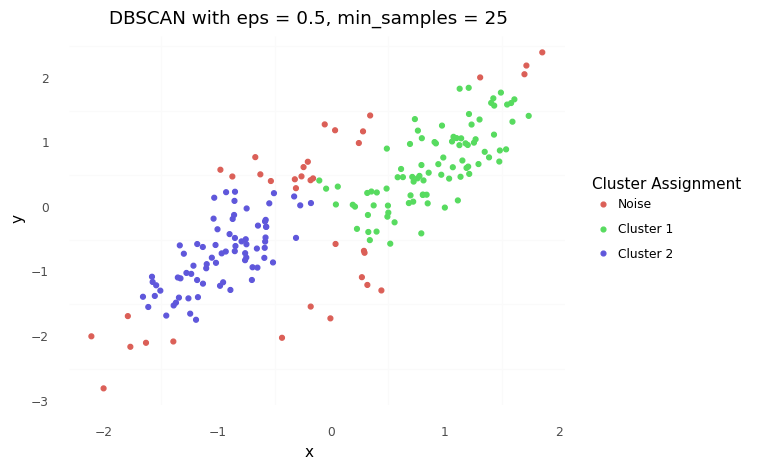

<ggplot: (8744527148473)>

In [122]:
# dbscan and plot
db1 = DBSCAN(eps = 0.5, min_samples = 25).fit(d1)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

d1["assignments"] = db1.labels_

(ggplot(d1, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 25"))

In [123]:
# grab only clustered data points
d1_clustered = d1.loc[(d1.assignments >= 0)]

silhouette_score(d1_clustered[["x","y"]], d1_clustered["assignments"])

0.6169609560667532

In [124]:
# overall 
silhouette_score(d1[["x","y"]], d1["assignments"])

0.39760284702143056

## Dataset 2

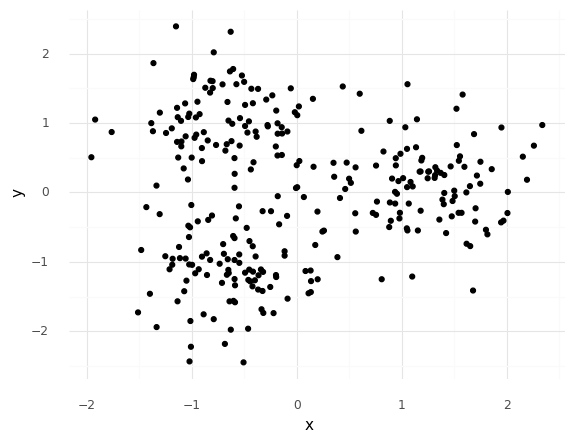

<ggplot: (8744526674017)>

In [125]:
d2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM2.csv")

z = StandardScaler()
d2[["x","y"]] = z.fit_transform(d2)

ggplot(d2, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

In [126]:
d2

,x,y
0,1.581164,1.410464
1,1.751127,0.442654
2,1.525696,0.682659
3,1.321153,0.363577
4,0.978797,-0.374213
...,...,...
295,-0.522887,1.685059
296,-0.195364,1.179569
297,0.005002,1.113126
298,-1.957708,0.507403


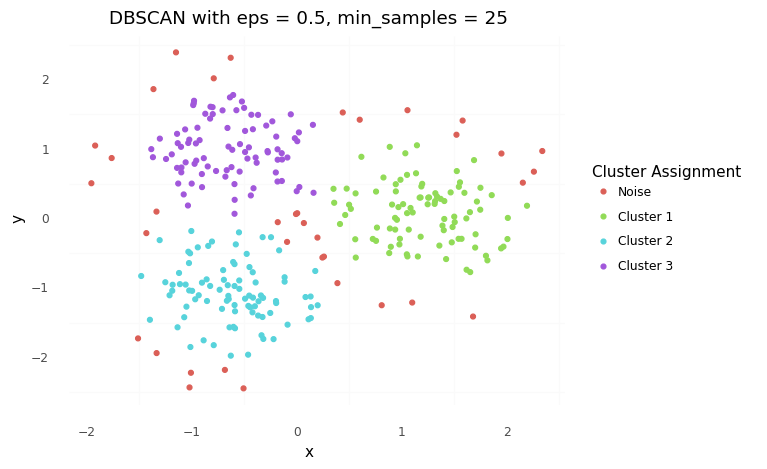

<ggplot: (8744526504913)>

In [127]:
db2 = DBSCAN(eps = 0.5, min_samples = 25).fit(d2)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db2.labels_)))]

d2["assignments"] = db2.labels_
(ggplot(d2, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 25"))

In [128]:
# grab only clustered data points
d2_clustered = d2.loc[(d2.assignments >= 0)]

print(silhouette_score(d2_clustered[["x","y"]], d2_clustered["assignments"]))

# overall 
print(silhouette_score(d2[["x","y"]], d2["assignments"]))

0.6140043544818719
0.4803831307840633


## Dataset 3

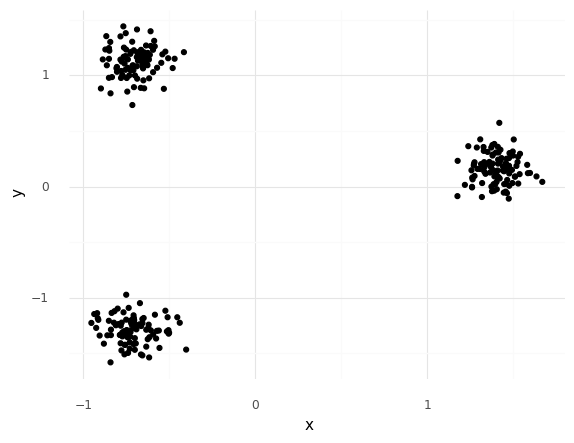

<ggplot: (8744526536305)>

In [129]:
d3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM3.csv")

z = StandardScaler()
d3[["x","y"]] = z.fit_transform(d3)

ggplot(d3, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

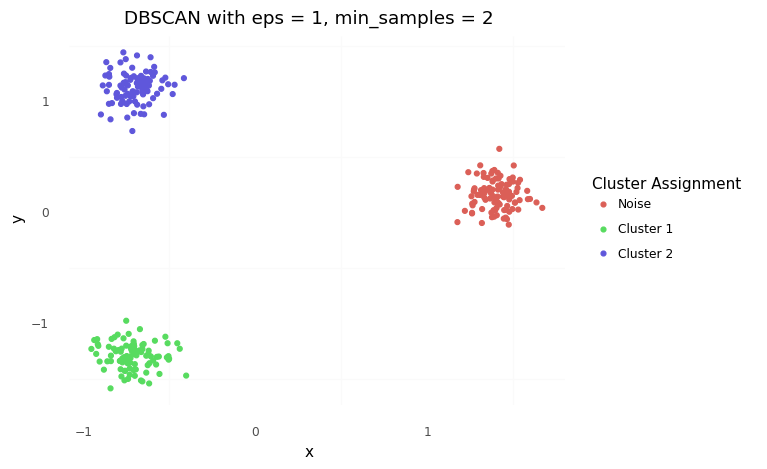

<ggplot: (8744526732165)>

In [130]:
db3 = DBSCAN(eps = 1, min_samples = 2).fit(d3)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db3.labels_)))]

d3["assignments"] = db3.labels_

(ggplot(d3, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 1, min_samples = 2"))

In [131]:
# grab only clustered data points
d3_clustered = d3.loc[(d3.assignments >= 0)]

print(silhouette_score(d3_clustered[["x","y"]], d3_clustered["assignments"]))

# overall 
print(silhouette_score(d3[["x","y"]], d3["assignments"]))

0.913619050733588
0.913619050733588


## Dataset 4

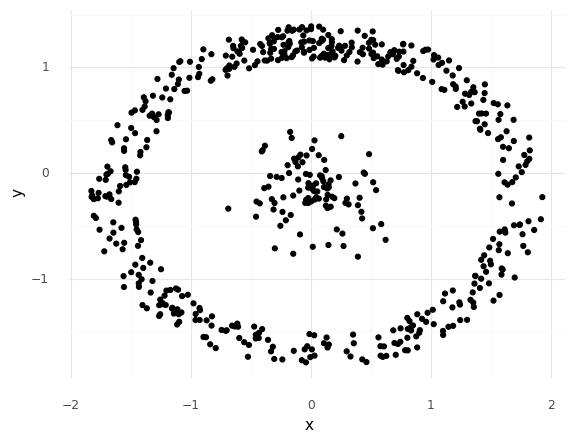

<ggplot: (8744526538037)>

In [132]:
d4 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM4.csv")

z = StandardScaler()
d4[["x","y"]] = z.fit_transform(d4)

ggplot(d4, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

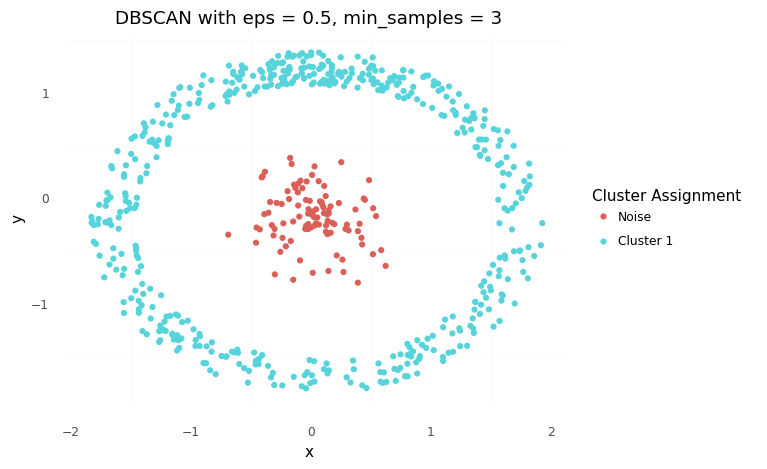

<ggplot: (8744527151765)>

In [133]:
db4 = DBSCAN(eps = 0.5, min_samples = 3).fit(d4)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db4.labels_)))]

d4["assignments"] = db4.labels_

(ggplot(d4, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 3"))

In [134]:
# grab only clustered data points
d4_clustered = d4.loc[(d4.assignments >= 0)]

print(silhouette_score(d4_clustered[["x","y"]], d4_clustered["assignments"]))

# overall 
print(silhouette_score(d4[["x","y"]], d4["assignments"]))

-0.042911477754913246
-0.042911477754913246


### Compare

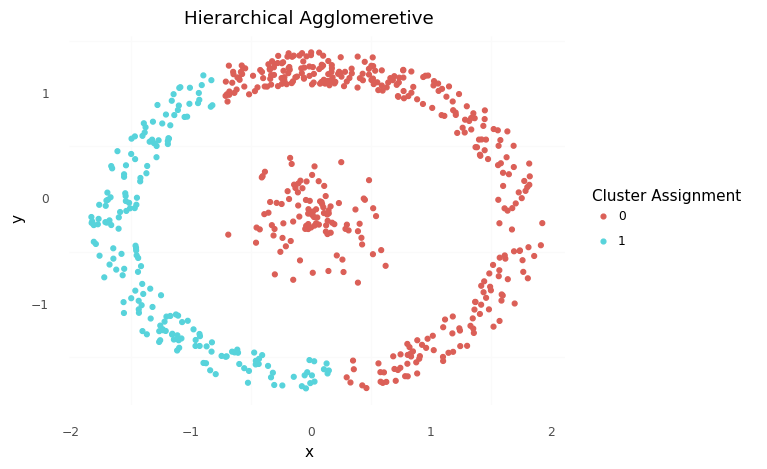

<ggplot: (8744526977977)>


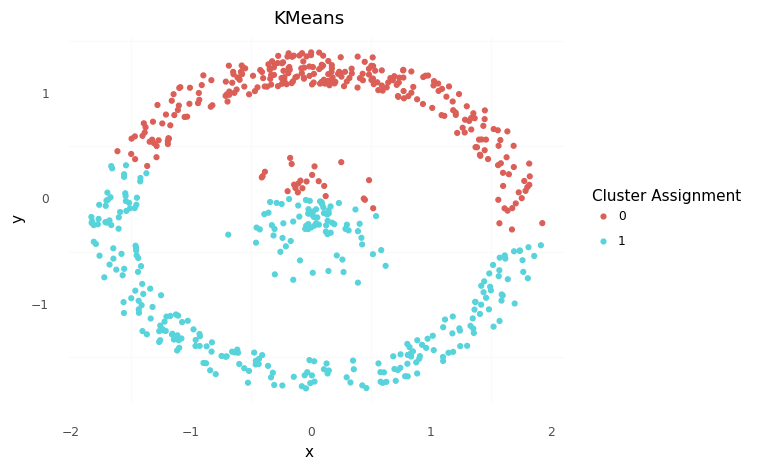

<ggplot: (8744534887737)>


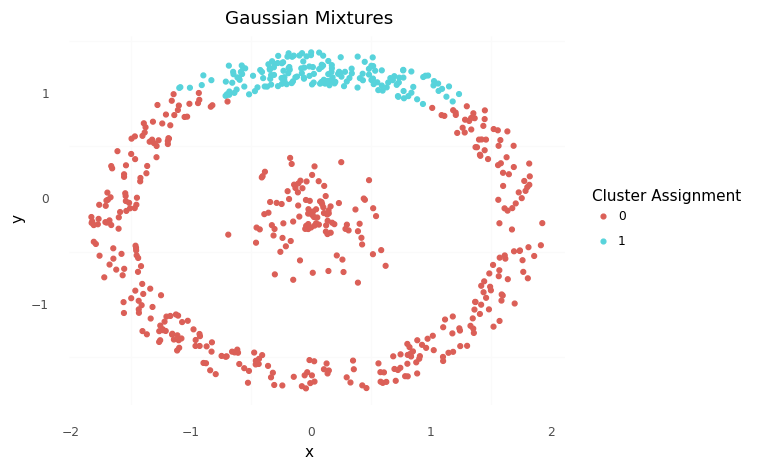

<ggplot: (8744526840749)>


In [135]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

hac = AgglomerativeClustering(2)
km = KMeans(2)
gm = GaussianMixture(2)

hac.fit(d4[["x","y"]])
km.fit(d4[["x","y"]])
gm.fit(d4[["x","y"]])

d4["hac"] = hac.labels_
d4["km"] = km.labels_
d4["gm"] = gm.predict(d4[["x","y"]])


print(ggplot(d4, aes(x = "x", y = "y",
                    color = "factor(hac)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Hierarchical Agglomeretive"))


print(ggplot(d4, aes(x = "x", y = "y",
                    color = "factor(km)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "KMeans"))


print(ggplot(d4, aes(x = "x", y = "y",
                    color = "factor(gm)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Gaussian Mixtures"))

## Dataset 5

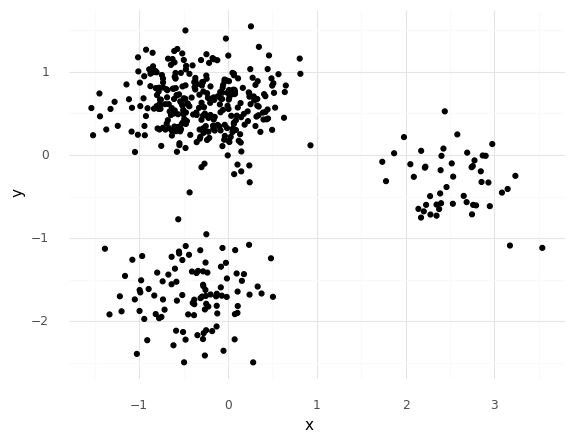

<ggplot: (8744526926461)>

In [136]:
d5 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM5.csv")

z = StandardScaler()
d5[["x","y"]] = z.fit_transform(d5)

ggplot(d5, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

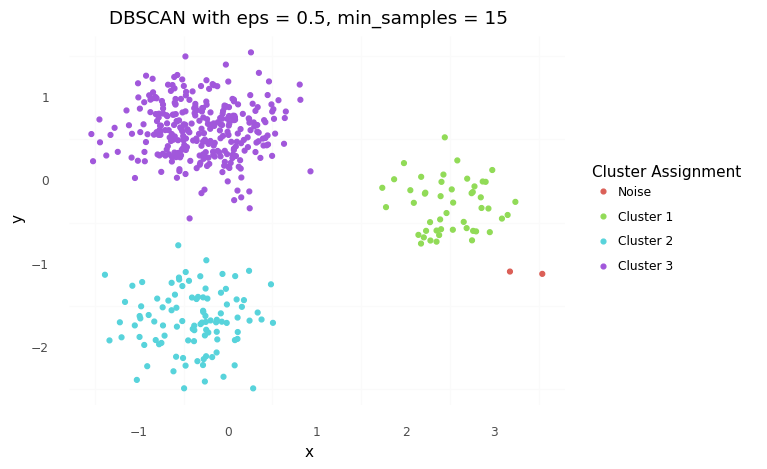

<ggplot: (8744526857397)>

In [137]:
db5 = DBSCAN(eps = 0.5, min_samples = 15).fit(d5)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db5.labels_)))]

d5["assignments"] = db5.labels_

(ggplot(d5, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 15"))

In [138]:
# grab only clustered data points
d5_clustered = d5.loc[(d5.assignments >= 0)]

print(silhouette_score(d5_clustered[["x","y"]], d5_clustered["assignments"]))

# overall 
print(silhouette_score(d5[["x","y"]], d5["assignments"]))

0.7048131054311416
0.6714107830551044


# Elbow Method

Read more [here](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) if math excites you.

## Dataset 6

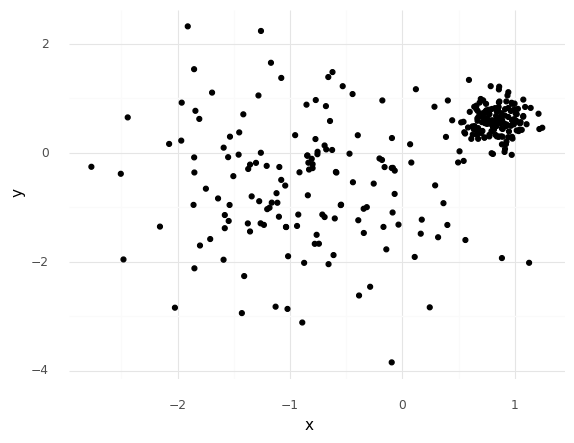

<ggplot: (8744535283621)>

In [139]:
d6 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM6.csv")

z = StandardScaler()
d6[["x","y"]] = z.fit_transform(d6)

ggplot(d6, aes(x = "x", y = "y")) + geom_point() + theme_minimal()

In [140]:
# we ask for mins + 1 nearest, because the data point it self (distance = 0) is included
mins = 3
nn = NearestNeighbors()

nn.fit(d6)

distances, neighbors = nn.kneighbors(d6)

distances

array([[0.        , 0.03690981, 0.04037236, 0.04597748, 0.05401608],
       [0.        , 0.05516926, 0.08888159, 0.08986399, 0.12363566],
       [0.        , 0.01648388, 0.02195778, 0.02314588, 0.03917653],
       ...,
       [0.        , 0.06869733, 0.07309685, 0.07758794, 0.09791749],
       [0.        , 0.45863691, 0.62402991, 0.6937056 , 0.74851932],
       [0.        , 0.3352202 , 0.35858311, 0.4012105 , 0.46639806]])

In [141]:
# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

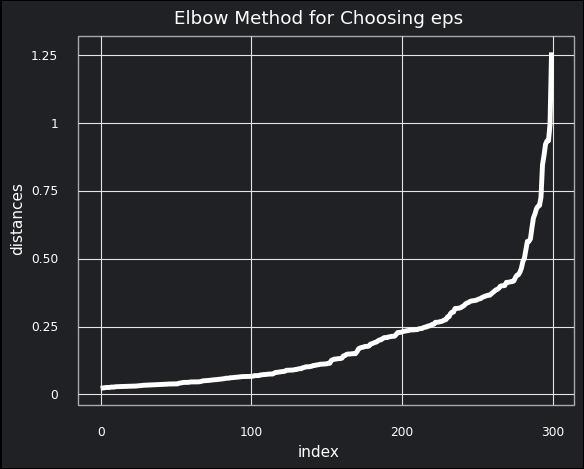

<ggplot: (8744527129097)>

In [142]:
#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
plt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "white", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
 theme(panel_grid_minor = element_blank(),
      rect = element_rect(fill = "#202124ff"),
      axis_text = element_text(color = "white"),
      axis_title = element_text(color = "white"),
      plot_title = element_text(color = "white"),
      panel_border = element_line(color = "darkgray"),
      plot_background = element_rect(fill = "#202124ff")
      ))
ggsave(plot=plt, filename='elbow.png', dpi=300)

plt

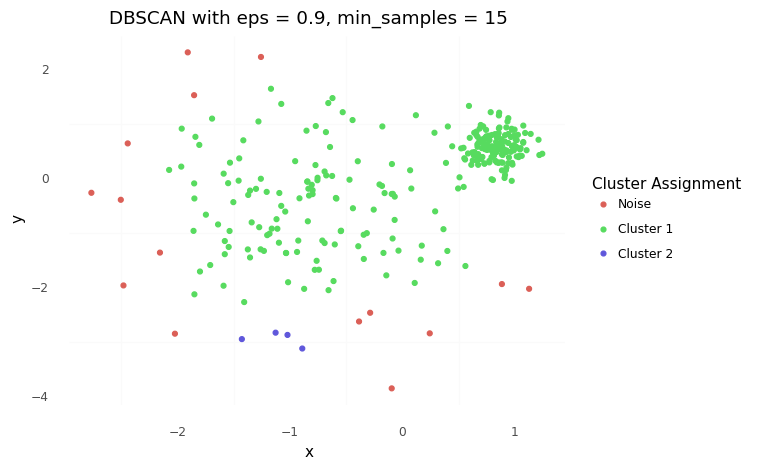

<ggplot: (8744535293321)>

In [143]:
db6 = DBSCAN(eps = 0.45, min_samples = 3).fit(d6)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db6.labels_)))]

d6["assignments"] = db6.labels_

(ggplot(d6, aes(x = "x", y = "y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.9, min_samples = 15"))

In [144]:

d6_clustered = d6.loc[(d6.assignments >= 0)]

print(silhouette_score(d6_clustered[["x","y"]], d6_clustered["assignments"]))

print(silhouette_score(d6[["x","y"]], d6["assignments"]))

0.49007245503214775
0.396045290883704
